# Start Spark session

In [72]:
from pyspark.sql import SparkSession

In [73]:
spark = SparkSession.builder.appName("Model_Deployment").getOrCreate()

# Load Data

In [85]:
file_location = "bank-full.csv"
file_type = "csv"
infer_schema="False"
first_row_is_header="True"
delimeter=";"

In [86]:
df = spark.read.format(file_type)\
.option("inferSchema",infer_schema)\
.option("header",first_row_is_header)\
.option("sep",delimeter)\
.load(file_location)

In [87]:
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

# Feature engineering

In [88]:
from pyspark.sql import functions as F

In [89]:
df = df.withColumn('y',F.when(F.col("y")=='yes',1).otherwise(0)) # one hot encoding for target variable

In [90]:
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown|  0|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown|  0|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown|  0|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown|  0|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

In [91]:
def variable_type(df):
    # use the dtypes to separate character and numeric variables
    vars_list = df.dtypes
    char_vars = [] #character variable list
    num_vars = [] # numeric variable list
    for variable in vars_list:
        if variable[1] in ('string'):
            char_vars.append(variable[0])
        else:
            num_vars.append(variable[0])
    return char_vars, num_vars

In [92]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import count, when, isnan, col

In [93]:
char_vars, num_vars = variable_type(df)

In [94]:
target_variable_name = 'y'

In [95]:
num_vars.remove(target_variable_name)

In [96]:
def category_to_index(df,char_vars):
    char_df = df.select(char_vars)
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_index", handleInvalid="keep") for c in char_df.columns]
    pipeline = Pipeline(stages=indexers)
    char_labels = pipeline.fit(char_df)
    df = char_labels.transform(df)
    return df, char_labels

In [97]:
df, char_labels = category_to_index(df, char_vars)
df = df.select([c for c in df.columns if c not in char_vars])

In [98]:
char_labels

PipelineModel_cf596be8e255

In [99]:
df.show()

+---+---------+---------+-------------+---------------+-------------+-------------+-------------+----------+-------------+---------+-----------+--------------+--------------+-----------+--------------+--------------+
|  y|age_index|job_index|marital_index|education_index|default_index|balance_index|housing_index|loan_index|contact_index|day_index|month_index|duration_index|campaign_index|pdays_index|previous_index|poutcome_index|
+---+---------+---------+-------------+---------------+-------------+-------------+-------------+----------+-------------+---------+-----------+--------------+--------------+-----------+--------------+--------------+
|  0|     33.0|      1.0|          0.0|            1.0|          0.0|       2117.0|          0.0|       0.0|          1.0|      5.0|        0.0|         243.0|           0.0|        0.0|           0.0|           0.0|
|  0|     17.0|      2.0|          1.0|            0.0|          0.0|         83.0|          0.0|       0.0|          1.0|      5.0|

In [100]:
def rename_columns(df, char_vars):
    mapping = dict(zip([i + "_index" for i in char_vars], char_vars))
    df = df.select([col(c).alias(mapping.get(c,c)) for c in df.columns])
    return df

In [101]:
df = rename_columns(df, char_vars)

In [102]:
df.show()

+---+----+----+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+
|  y| age| job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|
+---+----+----+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+
|  0|33.0| 1.0|    0.0|      1.0|    0.0| 2117.0|    0.0| 0.0|    1.0|5.0|  0.0|   243.0|     0.0|  0.0|     0.0|     0.0|
|  0|17.0| 2.0|    1.0|      0.0|    0.0|   83.0|    0.0| 0.0|    1.0|5.0|  0.0|    40.0|     0.0|  0.0|     0.0|     0.0|
|  0| 2.0| 7.0|    0.0|      0.0|    0.0|    2.0|    0.0| 1.0|    1.0|5.0|  0.0|    37.0|     0.0|  0.0|     0.0|     0.0|
|  0|18.0| 0.0|    0.0|      3.0|    0.0| 1359.0|    0.0| 0.0|    1.0|5.0|  0.0|    15.0|     0.0|  0.0|     0.0|     0.0|
|  0| 2.0|11.0|    1.0|      3.0|    0.0|    1.0|    1.0| 0.0|    1.0|5.0|  0.0|   123.0|     0.0|  0.0|     0.0|     0.0|
|  0| 4.0| 1.0| 

In [103]:
def assemble_vectors(df,features_list,target_variable_name):
    stages = []
    # assemble vectors
    assembler = VectorAssembler(inputCols=features_list,outputCol='features')
    stages=[assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name,'features'] + features_list
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel =pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)
    return df, assembleModel, selectedCols

In [104]:
# exclude target variable and select other feature vectors
features_list =df.columns
features_list.remove(target_variable_name)
df, assembleModel, selectedCols= assemble_vectors(df, features_list, target_variable_name)

In [105]:
df.show()

+---+--------------------+----+----+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+
|  y|            features| age| job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|
+---+--------------------+----+----+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+
|  0|(16,[0,1,3,5,8,9,...|33.0| 1.0|    0.0|      1.0|    0.0| 2117.0|    0.0| 0.0|    1.0|5.0|  0.0|   243.0|     0.0|  0.0|     0.0|     0.0|
|  0|(16,[0,1,2,5,8,9,...|17.0| 2.0|    1.0|      0.0|    0.0|   83.0|    0.0| 0.0|    1.0|5.0|  0.0|    40.0|     0.0|  0.0|     0.0|     0.0|
|  0|(16,[0,1,5,7,8,9,...| 2.0| 7.0|    0.0|      0.0|    0.0|    2.0|    0.0| 1.0|    1.0|5.0|  0.0|    37.0|     0.0|  0.0|     0.0|     0.0|
|  0|(16,[0,3,5,8,9,11...|18.0| 0.0|    0.0|      3.0|    0.0| 1359.0|    0.0| 0.0|    1.0|5.0|  0.0|    15.0|     0.0|  0.0|     0.0|  

In [106]:
assembleModel

PipelineModel_548cee3cf7e0

In [107]:
selectedCols

['y',
 'features',
 'age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome']

# Modelling

In [109]:
train, test = df.randomSplit([0.7,0.3],seed=12345)

In [110]:
train.count(), test.count()

(31559, 13652)

In [111]:
from pyspark.ml.classification import RandomForestClassifier

In [112]:
clf = RandomForestClassifier(featuresCol = 'features',labelCol='y',maxBins = 7169)

In [113]:
clf_model = clf.fit(train)

In [114]:
print(clf_model.featureImportances)

(16,[0,1,2,3,5,6,7,8,9,10,11,12,13,14,15],[0.02186537058951718,0.0026188180313093377,0.0007187000422634136,0.0002016646033454608,0.44554837995176655,0.01767247185149186,0.003232821035135271,0.00943042694145861,0.004544586928099005,0.05732894790193127,0.2790647747331575,0.0003709521913899377,0.06456294054817088,0.023137679544876735,0.06970146510608678])


print(clf_model.toDebugString)

In [115]:
train_pred_result = clf_model.transform(train)

In [116]:
test_pred_result = clf_model.transform(test)

In [117]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [118]:
from pyspark.sql.types import IntegerType, DoubleType

In [119]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [120]:
def evaluation_metrics(df, target_variable_name):
    pred = df.select("prediction", target_variable_name)
    pred =pred.withColumn(target_variable_name, pred[target_variable_name].cast(DoubleType()))
    pred =pred.withColumn("prediction", pred["prediction"].cast(DoubleType()))
    metrics = MulticlassMetrics(pred.rdd.map(tuple))
    # confusion matrix
    cm = metrics.confusionMatrix().toArray()
    acc = metrics.accuracy
    misclassification_rate = 1 - acc
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1 = metrics.fMeasure(1.0)
    evaluator_roc = BinaryClassificationEvaluator(labelCol = target_variable_name, rawPredictionCol = 'rawPrediction',metricName = 'areaUnderROC')
    roc = evaluator_roc.evaluate(df)
    evaluator_pr = BinaryClassificationEvaluator(labelCol = target_variable_name, rawPredictionCol = 'rawPrediction',metricName = 'areaUnderPR')
    pr = evaluator_pr.evaluate(df)
    return cm, acc, misclassification_rate, precision, recall, f1, roc, pr

In [121]:
train_cm, train_acc, train_miss_rate,train_precision,train_recall, train_f1, train_roc, train_pr = evaluation_metrics(train_pred_result, target_variable_name)

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [122]:
test_cm, test_acc, test_miss_rate,test_precision,test_recall, test_f1, test_roc, test_pr = evaluation_metrics(test_pred_result, target_variable_name)

In [123]:
# Comparison of metrics

In [124]:
print('Train accuracy - ', train_acc,' Test accuracy - ', test_acc)

Train accuracy -  0.9108019899236351  Test accuracy -  0.896938177556402


In [125]:
print('Train misclassification rate - ', train_miss_rate, ', Test misclassification rate - ', test_miss_rate)

Train misclassification rate -  0.08919801007636485 , Test misclassification rate -  0.10306182244359796


In [126]:
print('Train precision - ', train_precision, ', Test precision - ', test_precision)

Train precision -  0.9670223084384093 , Test precision -  0.6529411764705882


In [127]:
print('Train recall - ', train_recall, ', Test misclassification rate - ', test_recall)

Train recall -  0.26389624139756485 , Test misclassification rate -  0.1469225678358703


In [128]:
print('Train f1 score - ', train_f1, ', Test misclassification rate - ', test_f1)

Train f1 score -  0.41463921813266796 , Test misclassification rate -  0.23987034035656402


In [129]:
print('Train ROC - ', train_roc, ', Test ROC - ', test_roc)

Train ROC -  0.9567075560685466 , Test ROC -  0.8226896997996894


In [130]:
print('Train PR - ', train_pr, ', Test PR - ', test_pr)

Train PR -  0.7814022653478618 , Test PR -  0.41212115719915343


In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

In [132]:
def make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test):
    
    list_values = ['0','1']
    
    plt.figure(1, figsize=(10,5))
    plt.subplot(121)
    sns.heatmap(cf_matrix_train, annot=True, yticklabels=list_values,xticklabels = list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,len(list_values)])
    plt.title('Train data predictions')
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=list_values, xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,len(list_values)])
    plt.title('Test data predictions')
    plt.tight_layout()
    return None

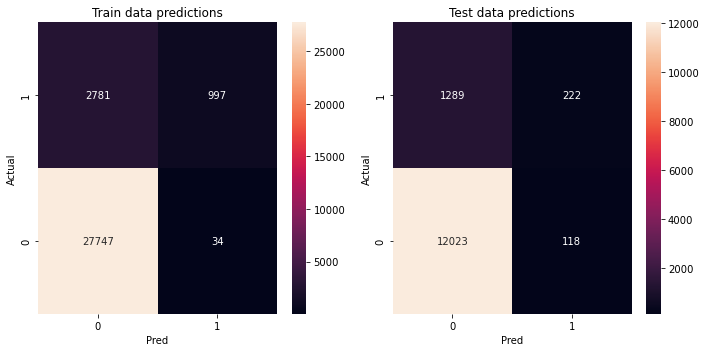

In [133]:
make_confusion_matrix_chart(train_cm, test_cm)

In [45]:
# Model deployment

In [46]:
import os
import pickle

In [47]:
path_to_write_output = 'deploy'

In [48]:
try:
    os.mkdir(path_to_write_output)
except:
    pass

In [50]:
char_labels.write().overwrite().save(path_to_write_output+'/char_label_model.h5')

In [51]:
assembleModel.write().overwrite().save(path_to_write_output+'/assembleModel.h5')
clf_model.write().overwrite().save(path_to_write_output+'/clf_model.h5')

In [52]:
list_of_vars = [features_list, char_vars,num_vars]
with open(path_to_write_output +'/file.pkl','wb') as handle:
    pickle.dump(list_of_vars,handle)

In [53]:
# load models

In [57]:
from pyspark.sql import functions as F
import pickle
from pyspark.ml import PipelineModel
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, DoubleType

In [60]:
path_to_read_objects = 'deploy'

In [61]:
char_labels = PipelineModel.load(path_to_read_objects+'/char_label_model.h5')
assembleModel = PipelineModel.load(path_to_read_objects+'/assembleModel.h5')
clf_model = RandomForestClassificationModel.load(path_to_read_objects+'/clf_model.h5')

In [62]:
with open(path_to_read_objects +'/file.pkl','rb') as handle:
    features_list,char_vars, num_vars = pickle.load(handle)

In [63]:
def rename_columns(df, char_vars):
    mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
    df = df.select([F.col(c).alias(mapping.get(c, c)) for c in df.columns])
    return df

In [64]:
# score the new data
def score_new_df(scoredf):
    X = scoredf.select(features_list)
    X = char_labels.transform(x)
    X = X.select([c for c in X.columns if c not in char_vars])
    X = rename_columns(X, char_vars)
    final_X = assembleModel.transform(X)
    final_X.cache()
    pred = clf_model.transform(final_x)
    pred.cache()
    split_udf = udf(lambda value: value[1].item(), DoubleType())
    pred = pred.select('prediction', split_udf('probability').alias('probability'))
    return pred